,RAKE,YAKE,TXTR,KBRT,MPTE
all_docs,79.00,79.00,79.00,79.00,79.00
self_top1,1.00,1.00,0.00,1.00,1.00
soft,0.32,0.66,0.08,0.61,0.03
hard,0.01,0.04,0.01,0.05,0.00
avg,0.12,0.28,0.03,0.22,0.01
no_relevant,0.00,0.00,1.00,0.00,0.00


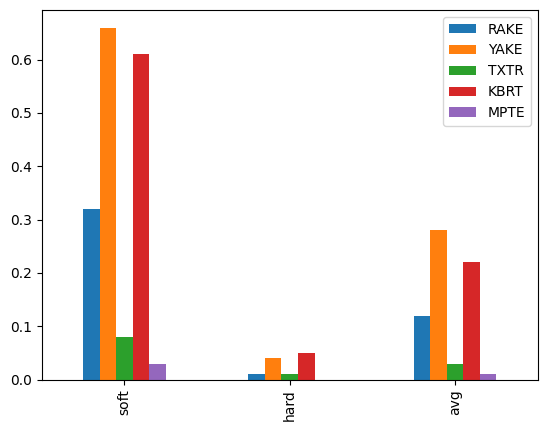

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


BASE_PATH = Path("data") / "eval"

with open(BASE_PATH / "eval.json") as file:
    rawdata = json.load(file)
data = {i: {} for i in rawdata.keys()}
for k, v in rawdata.items():
    for k1, v1 in v.items():
        if k1 not in ["all_docs", "self_top1", "no_relevant"]:
            data[k][k1] = v1

data = pd.DataFrame(data)
# plt.legend()
# plt.hist(data)

data.plot.bar()
# data
pd.DataFrame(rawdata)

In [2]:
# UPDATE 56 field
from documents import FileSystem
import json


async for doc in FileSystem("data\\raw\\skolkovo"):
    with open("data\\eval\\kwe\\" + doc.id + ".json", encoding="utf-8") as file:
        data = json.load(file)
    data["56"] = doc.citations
    with open("data\\eval\\kwe\\" + doc.id + ".json", "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)